In [ ]:
%matplotlib inline

In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, multilabel_confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
df = pd.read_csv('dataset.csv')

df.head()

,summary,category
0,We investigate the strength and the directio...,q-fin.ST
1,Financial technology (FinTech) has drawn muc...,cs.LG
2,It seems to be very unlikely that all releva...,q-fin.ST
3,An emerging approach to data-limited fisheri...,q-bio.PE
4,Stock market prediction with forecasting alg...,q-fin.ST


In [ ]:
# Удаление подкатегорий с помощью регулярного выражения
df['category'] = df['category'].str.extract(r'(.*)\.')
df = df.dropna()

df.head()

,summary,category
0,We investigate the strength and the directio...,q-fin
1,Financial technology (FinTech) has drawn muc...,cs
2,It seems to be very unlikely that all releva...,q-fin
3,An emerging approach to data-limited fisheri...,q-bio
4,Stock market prediction with forecasting alg...,q-fin


In [ ]:
# Сохранение извлеченных данных в переменные
summary = []
category = []

for index, row in df.iterrows():
    summary.append(row['summary'])
    category.append(row['category'])

print(f'Образец аннотации: \n{summary[0]}\nОбразец категории:\n{category[0]}')

Образец аннотации: 
  We investigate the strength and the direction of information transfer in the
U.S. stock market between the composite stock price index of stock market and
prices of individual stocks using the transfer entropy. Through the
directionality of the information transfer, we find that individual stocks are
influenced by the index of the market.

Образец категории:
q-fin


In [ ]:
# получение списка уникальных категорий и их частотности
np.unique(category, return_counts=True)

(array(['astro-ph', 'cond-mat', 'cs', 'econ', 'eess', 'math', 'nlin',
        'physics', 'q-bio', 'q-fin', 'stat'], dtype='<U8'),
 array([  93,  387, 1451,  215,   74,  693,   49,  529, 1216, 1613,  245]))

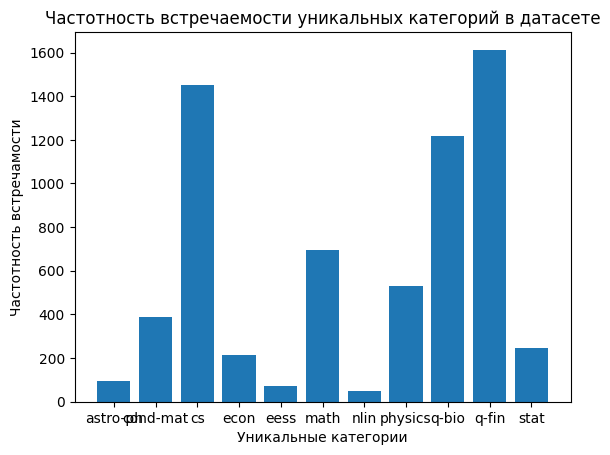

In [ ]:
# визуализация
labels, occurences = np.unique(category, return_counts=True)

plt.bar(labels, occurences)
plt.xlabel('Уникальные категории')
plt.ylabel('Частотность встречамости')
plt.title('Частотность встречаемости уникальных категорий в датасете')
plt.show()

In [ ]:
# укрупнение категорий
df['category'] = df['category'].replace({'astro-ph': 'physics', 'stat': 'math', 'nlin': 'physics', 'eess': 'cs', 'econ': 'q-fin', 'cond-mat': 'physics'})

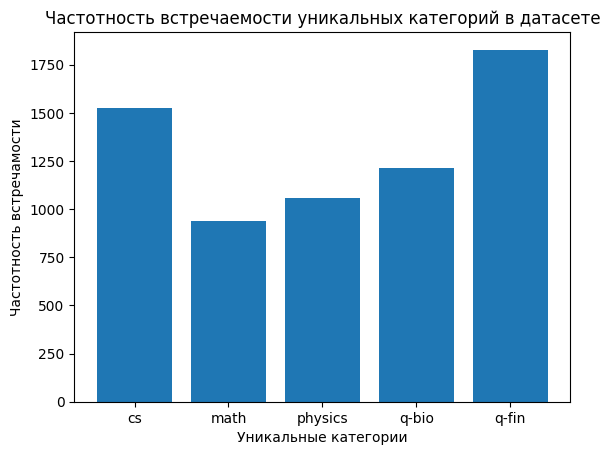

In [ ]:
summary = []
category = []

for index, row in df.iterrows():
    summary.append(row['summary'])
    category.append(row['category'])

labels, occurences = np.unique(category, return_counts=True)

plt.bar(labels, occurences)
plt.xlabel('Уникальные категории')
plt.ylabel('Частотность встречамости')
plt.title('Частотность встречаемости уникальных категорий в датасете')
plt.show()

МАШИННОЕ ОБУЧЕНИЕ

In [ ]:
x_train, x_temp, y_train, y_temp = train_test_split(summary, category, test_size=0.6)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5)

In [ ]:
print(x_test[5])
print(y_test[5])

  We show that in the recent artificial light-harvesting experiment [Angewandte
Chemie Intl. Ed. 55, 2759 (2016)] on organic nanocrystals self-assembled from
difluoroboron chromophores, the spontaneous emission of an excited pigment
should undergo a two-step process. It would first decay to an excitonic
polariton confined by cavity resonance via strong photon-exciton coupling. The
captive intermediate could then funnel the energy directly to doped acceptors,
leading to the observed over 90% transfer efficiency at less than 1/1000
acceptor-donor ratio. Theoretical, parameter-free analyses are in quantitative
agreement with the experiment.

physics


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(summary)
tokenizer.word_index['<PAD>'] = 0

In [ ]:
train_sequences = tokenizer.texts_to_sequences(x_train)
val_sequences = tokenizer.texts_to_sequences(x_val)
test_sequences = tokenizer.texts_to_sequences(x_test)

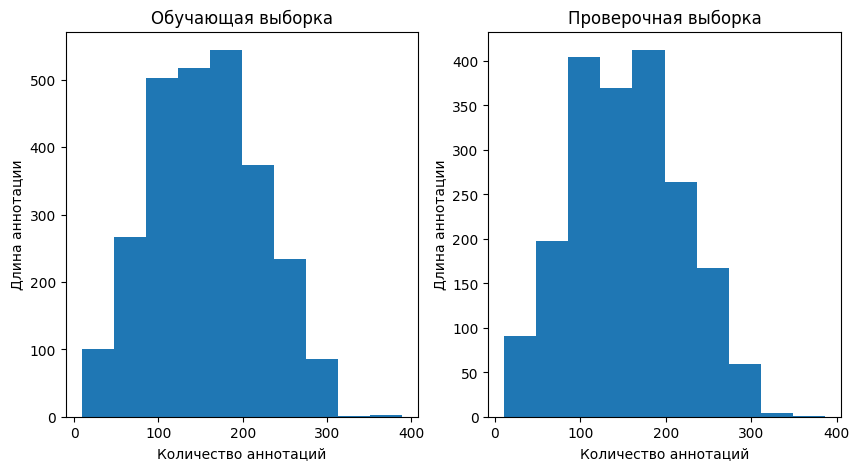

In [ ]:
train_len = [len(summary) for summary in train_sequences]
val_len = [len(summary) for summary in val_sequences]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].hist(train_len)
axs[1].hist(val_len)

axs[0].set_title('Обучающая выборка')
axs[1].set_title('Проверочная выборка')

for ax in axs:
  ax.set_xlabel('Количество аннотаций')
  ax.set_ylabel('Длина аннотации')

In [ ]:
# паддинг

MAX_SEQUENCE_LENGTH = 400

X_train = sequence.pad_sequences(train_sequences, maxlen = MAX_SEQUENCE_LENGTH)
X_val = sequence.pad_sequences(val_sequences, maxlen = MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen = MAX_SEQUENCE_LENGTH)

In [ ]:
# кодирование классов

le = LabelEncoder()

num_classes = len(labels)

Y_train = le.fit_transform(y_train)
Y_val = le.transform(y_val)
Y_test = le.transform(y_test)

Y_train = to_categorical(Y_train, num_classes=num_classes)
Y_val = to_categorical(Y_val, num_classes=num_classes)
Y_test = to_categorical(Y_test, num_classes=num_classes)

Сборка модели

In [ ]:
VOCAB_SIZE = len(tokenizer.word_index)
EMBED_SIZE = 50
EPOCHS = 10
BATCH_SIZE = 8
NUM_CLASSES = num_classes

In [ ]:
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(NUM_CLASSES, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_28 (Embedding)    (None, 400, 50)           1440100   
                                                                 
 conv1d_84 (Conv1D)          (None, 400, 64)           12864     
                                                                 
 max_pooling1d_84 (MaxPoolin  (None, 200, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_85 (Conv1D)          (None, 200, 32)           8224      
                                                                 
 max_pooling1d_85 (MaxPoolin  (None, 100, 32)          0         
 g1D)                                                            
                                                                 
 conv1d_86 (Conv1D)          (None, 100, 32)         

In [ ]:
callback = EarlyStopping(monitor='loss', patience=3)

model.fit(X_train, Y_train,
          validation_split=0.1,
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          verbose=1,
          callbacks=[callback]
          )

Epoch 1/10
296/296 [==============================] - 33s 46ms/step - loss: 1.4657 - accuracy: 0.3474 - val_loss: 1.1225 - val_accuracy: 0.5361
Epoch 2/10
296/296 [==============================] - 13s 43ms/step - loss: 0.8153 - accuracy: 0.6970 - val_loss: 0.7607 - val_accuracy: 0.7224
Epoch 3/10
296/296 [==============================] - 13s 45ms/step - loss: 0.2752 - accuracy: 0.9031 - val_loss: 0.9889 - val_accuracy: 0.7414
Epoch 4/10
296/296 [==============================] - 13s 44ms/step - loss: 0.0742 - accuracy: 0.9767 - val_loss: 1.9365 - val_accuracy: 0.6692
Epoch 5/10
296/296 [==============================] - 13s 44ms/step - loss: 0.0617 - accuracy: 0.9771 - val_loss: 1.6411 - val_accuracy: 0.6996
Epoch 6/10
296/296 [==============================] - 15s 50ms/step - loss: 0.0500 - accuracy: 0.9831 - val_loss: 2.0636 - val_accuracy: 0.6958
Epoch 7/10
296/296 [==============================] - 13s 45ms/step - loss: 0.0281 - accuracy: 0.9937 - val_loss: 1.7932 - val_accuracy:

In [ ]:
scores = model.evaluate(X_val, Y_val, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

62/62 [==============================] - 1s 18ms/step - loss: 2.1688 - accuracy: 0.6866
Accuracy: 68.66%


Предсказывание

In [ ]:
predictions = model.predict(X_test)
predictions[:10]

62/62 [==============================] - 1s 17ms/step


array([[2.2483231e-04, 4.1699536e-02, 1.1472945e-04, 5.6450240e-09,
        9.5796084e-01],
       [3.0240346e-07, 2.3700942e-03, 7.0784503e-01, 2.8978458e-01,
        1.6165116e-10],
       [9.9999923e-01, 4.7906262e-11, 6.0883911e-12, 4.7947166e-13,
        7.6993598e-07],
       [5.1418669e-05, 3.9970232e-03, 5.2861315e-03, 9.9066544e-01,
        1.0301362e-09],
       [9.9994701e-01, 2.2289264e-07, 7.7468822e-09, 5.2709835e-05,
        5.7650151e-09],
       [3.3935722e-11, 8.7041990e-05, 9.9991149e-01, 1.4256348e-06,
        9.9957802e-12],
       [2.5421521e-01, 3.3904712e-09, 1.1523644e-09, 7.4578476e-01,
        9.2788258e-15],
       [1.9584176e-01, 1.5851761e-04, 7.7730318e-04, 8.0322093e-01,
        1.4951785e-06],
       [2.5410269e-21, 2.3997440e-08, 9.9999994e-01, 4.2437043e-11,
        4.2862806e-19],
       [2.1254928e-06, 5.8807310e-02, 8.6763543e-01, 2.6695737e-09,
        7.3555157e-02]], dtype=float32)

In [ ]:
preds = [np.argmax(predictions[i]) for i in range(len(predictions))]
preds[:10]

[4, 2, 0, 3, 0, 2, 3, 3, 2, 2]

In [ ]:
results = []

for p in preds:
  if p == 0:
    results.append('cs')
  elif p == 1:
    results.append('math')
  elif p == 2:
    results.append('physics')
  elif p == 3:
    results.append('q-bio')
  elif p == 4:
    results.append('q-fin')

for i in range(10):
  print(f'Пример {i}')
  print('Текст аннотации:', x_test[i])
  print('Правильный ответ:', y_test[i])
  print('Предсказанный ответ:', results[i])
  print()

Пример 0
Текст аннотации:   This paper is a continuation of Ishitani and Kato (2015), in which we derived
a continuous-time value function corresponding to an optimal execution problem
with uncertain market impact as the limit of a discrete-time value function.
Here, we investigate some properties of the derived value function. In
particular, we show that the function is continuous and has the semigroup
property, which is strongly related to the Hamilton-Jacobi-Bellman
quasi-variational inequality. Moreover, we show that noise in market impact
causes risk-neutral assessment to underestimate the impact cost. We also study
typical examples under a log-linear/quadratic market impact function with
Gamma-distributed noise.

Правильный ответ: q-fin
Предсказанный ответ: q-fin

Пример 1
Текст аннотации:   Reaction networks are systems in which the populations of a finite number of
species evolve through predefined interactions. Such networks are found as
modeling tools in many biological disci

In [ ]:
labels = ['cs', 'math', 'physics', 'q-bio', 'q-fin']
Y_pred = to_categorical(preds, num_classes=num_classes)
confusion_matrices = multilabel_confusion_matrix(y_test, results, labels = labels)
confusion_matrices

array([[[1403,  105],
        [ 169,  293]],

       [[1561,  117],
        [ 141,  151]],

       [[1544,  120],
        [ 149,  157]],

       [[1454,  166],
        [ 100,  250]],

       [[1264,  146],
        [  95,  465]]])

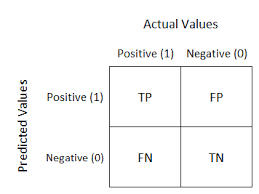

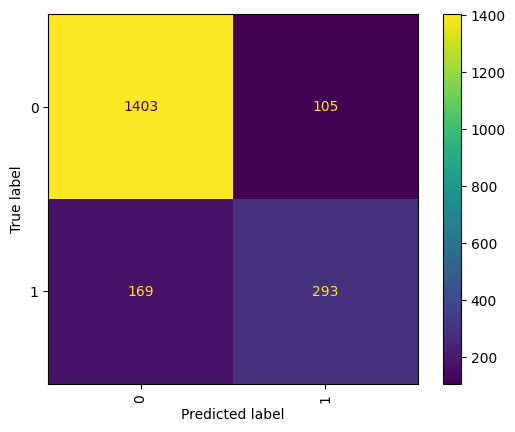

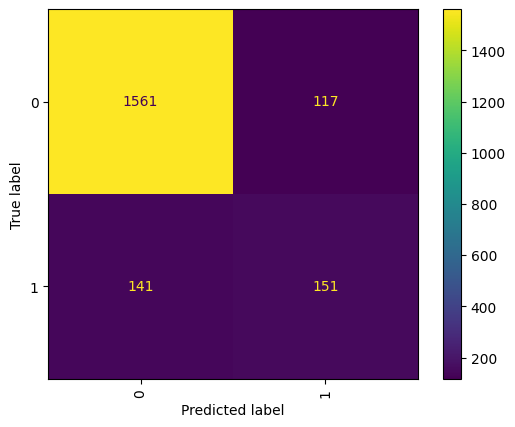

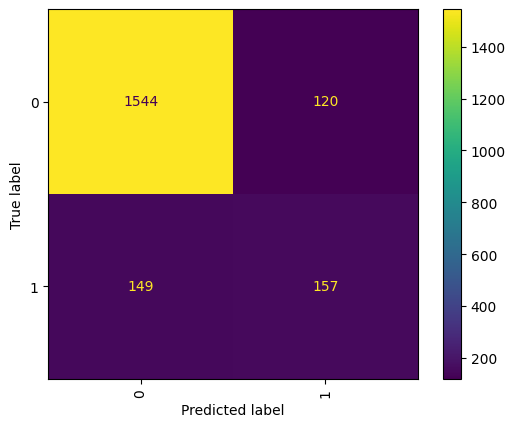

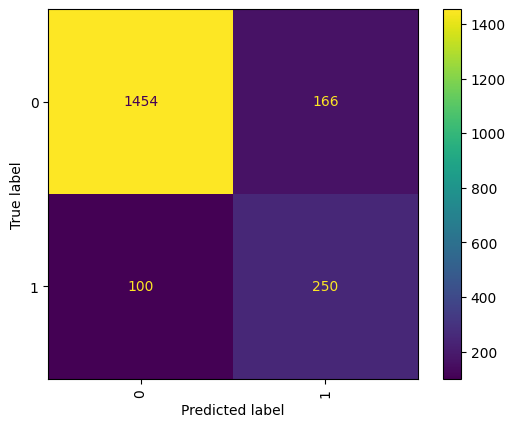

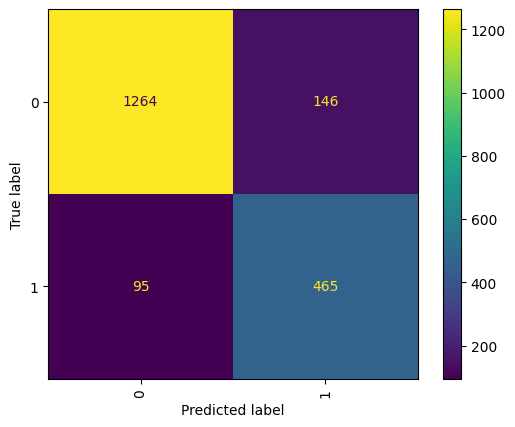

In [ ]:
for confusion_matrix in confusion_matrices:
    disp = ConfusionMatrixDisplay(confusion_matrix)
    disp.plot(include_values=True, ax=None, xticks_rotation="vertical")
    plt.show()